In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader as web
from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive


import warnings
warnings.filterwarnings('ignore')

def evaluate_arima_model(data, arima_order):
    train_size = int(len(data) * 0.8)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    return error

def find_best_order(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f"Order: {order}   MSE: {mse}")
                except:
                    continue
    return best_cfg

def run_ARIMA(ticker, steps_to_forecast):
    
    df = web.DataReader(ticker, data_source='yahoo', start='2014-01-01', end= '2021-06-08')
    df = df.filter(['Close'])
    
    p = range(0, 3)
    d = [1]
    q = range(0, 3)
    
    history = df[:int(len(df) - steps_to_forecast)].values
    
    params = find_best_order(history, p, d, q)

    model_fit = ARIMA(history, order = params).fit()
    
    pred_uc = model_fit.get_forecast(steps = steps_to_forecast, alpha = .05)
    pred_ci = pred_uc.conf_int()
    print('DONE')
    return pred_uc, pred_ci

def find_file_id(ticker, drive):
    name = f'{ticker}_ARIMA_forecasts'
    file_list = drive.ListFile({'q': f"'1kxtGrwVl0gscMq79quvISHmXhUg4ZDUZ' in parents and trashed=false"}).GetList()
    if (len(file_list) != 0):
        for file in file_list:
            if (name == file['title']):
                print(file['title'])
                return file['id']
            else:
                continue
    return None
                
    
def upload_file(ticker, drive):
    upload_file = f'D:\Project\VSASMTA\data\{ticker}_ARIMA_forecasts.csv'
    file = drive.CreateFile({'parents': [{'id': '1kxtGrwVl0gscMq79quvISHmXhUg4ZDUZ'}],
                             "mimeType": "text/csv", 
                             "title" : f"{ticker}_ARIMA_forecasts"})
    file.SetContentFile(upload_file)
    file.Upload()
    
def update_file(ticker, drive, file_id):
    upload_file = f'D:\Project\VSASMTA\data\{ticker}_ARIMA_forecasts.csv'
    file = drive.CreateFile({'id' : f'{file_id}',
                             "mimeType": "text/csv", 
                             "title" : f'{ticker}_ARIMA_forecasts'})
    file.SetContentFile(upload_file)
    file.Upload()

In [ ]:
n_step_forecast = int(input())

ticker_list = ('AAPL', 'MSFT', 'GOOG', 'GOOGL', 'FB', 'TSM', 'NVDA', 'ADBE', 'INTC', 'CSCO')

gauth = GoogleAuth()
gauth.LoadCredentialsFile("creds.txt")

if gauth.credentials is None:
    gauth.GetFlow()
    gauth.flow.params.update({'access_type': 'offline'})
    gauth.flow.params.update({'approval_prompt': 'force'})
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

gauth.SaveCredentialsFile("creds.txt")  

drive = GoogleDrive(gauth)

for ticker in ticker_list:
    pred_uc, pred_ci = run_ARIMA(ticker, n_step_forecast) 
    df = web.DataReader(ticker, data_source='yahoo', start='2014-01-01', end= '2021-06-08')
    df = df.filter(['Close'])
    set_dates = df[int(len(df) - n_step_forecast):].index
    
    values = np.array([pred_uc.predicted_mean, pred_ci[:, 0], pred_ci[:, 1]])
    values = values.transpose()

    forecasts = pd.DataFrame(data = values, columns = ["Predictions", "CI_lower", "CI_upper"])
    
    forecasts['Date'] = set_dates
    forecasts = forecasts[['Date', 'Predictions', 'CI_lower', 'CI_upper']]
    
    forecasts.to_csv(f'D:\Project\VSASMTA\data\{ticker}_ARIMA_forecasts.csv', index = False)
        
    file_id = find_file_id(ticker, drive)
    
    if(file_id):
        update_file(ticker, drive, file_id)
    else:
        upload_file(ticker, drive)

7
Order: (0, 1, 0)   MSE: 6.17408241342735


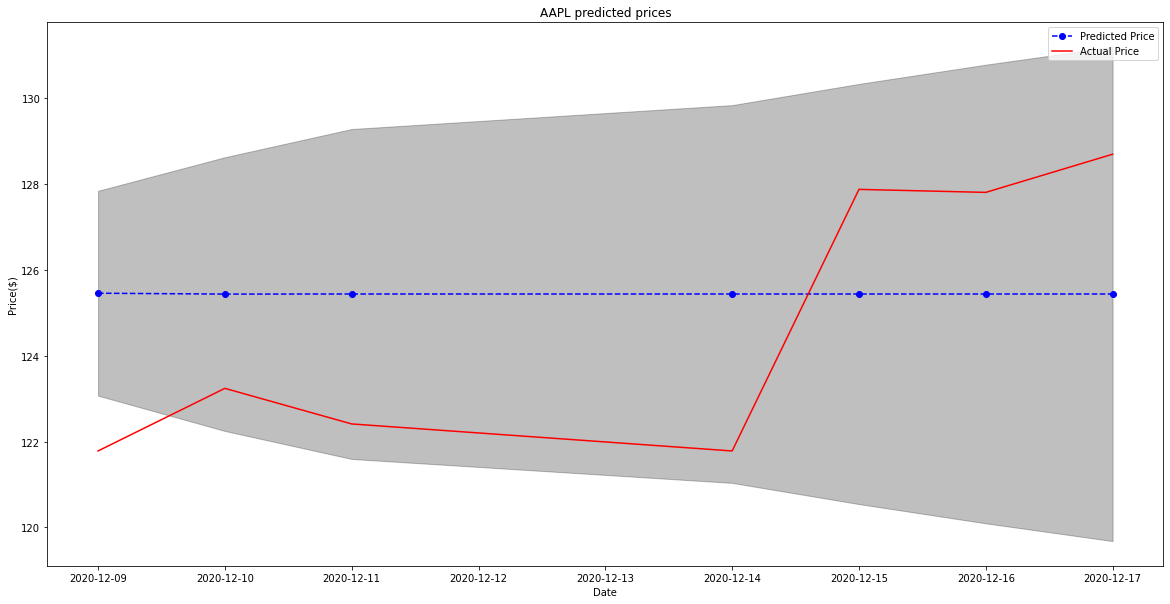

In [57]:
df = web.DataReader(ticker, data_source='yahoo', start='2014-01-01', end= '2020-12-17')
df = df.filter(['Close'])

test_set_range = df[int(len(df) - n_step_forecast):].index
test_set = df[int(len(df) - n_step_forecast):]

plt.figure(figsize = (20, 10))
plt.plot(test_set_range, pred_uc.predicted_mean, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_set, color='red', label='Actual Price')
plt.fill_between(test_set_range,
                 pred_ci[:, 0],
                 pred_ci[:, 1], color='k', alpha=.25)
plt.title(f'{ticker} predicted prices')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.legend()
plt.show()